In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"


In [38]:
ticker = yf.Ticker("AAPL")
data = ticker.history(period="5y") 

In [39]:
def sundial_predict(prices, forecast_length=5):

    if len(prices) < 20:
        return [prices[-1]] * forecast_length
    
    recent_trend = np.mean(np.diff(prices[-10:]))
    short_ma = np.mean(prices[-5:])
    long_ma = np.mean(prices[-20:])
    volatility = np.std(prices[-20:])
    
    predictions = []
    base_price = prices[-1]
    
    for i in range(forecast_length):
        trend_component = recent_trend * (0.8 ** i)
        
        momentum = (short_ma - long_ma) * 0.1 * (0.9 ** i)
        
        noise = np.random.normal(0, volatility * 0.05)
        
        predicted_price = base_price + trend_component + momentum + noise
        predictions.append(predicted_price)
        base_price = predicted_price
    
    return predictions

print("Sundial prediction function defined")


Sundial prediction function defined


In [40]:
test_period = 30 
predictions_list = []
actual_list = []

print("Testing short-term prediction accuracy...")

for i in range(len(data) - test_period - 5, len(data) - 5):
    historical_data = data['Close'].iloc[:i].values
    actual_future = data['Close'].iloc[i:i+5].values
    
    predicted = sundial_predict(historical_data, 5)
    
    predictions_list.extend(predicted)
    actual_list.extend(actual_future)

mse = mean_squared_error(actual_list, predictions_list)
mae = mean_absolute_error(actual_list, predictions_list)
mape = np.mean(np.abs((np.array(actual_list) - np.array(predictions_list)) / np.array(actual_list))) * 100

print(f"Short-term prediction metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: ${mae:.2f}")

# Direction accuracy
actual_directions = np.sign(np.diff(actual_list))
predicted_directions = np.sign(np.diff(predictions_list))
direction_accuracy = np.mean(actual_directions == predicted_directions) * 100
print(f"Direction accuracy: {direction_accuracy:.1f}%")


Testing short-term prediction accuracy...
Short-term prediction metrics:
MAPE: 2.38%
MAE: $4.79
Direction accuracy: 38.3%


In [41]:

class SundialTradingStrategy:
    def __init__(self, initial_capital=10000, commission=0.001):
        self.initial_capital = initial_capital
        self.commission = commission
        self.cash = initial_capital
        self.shares = 0
        self.trades = []
        self.portfolio_history = []
        
    def get_signal(self, historical_prices, current_price):
        if len(historical_prices) < 60:
            return 0  
        
        predicted_prices = sundial_predict(historical_prices, 5)
        expected_return = (predicted_prices[0] - current_price) / current_price
        
        if expected_return > 0.02:  
            return 1
        elif expected_return < -0.02:  
            return -1
        else:
            return 0  
    
    def execute_trade(self, price, signal, date):
        if signal == 1 and self.cash > 0:  
            shares_to_buy = self.cash // (price * (1 + self.commission))
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + self.commission)
                self.cash -= cost
                self.shares += shares_to_buy
                self.trades.append({
                    'date': date, 'action': 'BUY', 
                    'shares': shares_to_buy, 'price': price
                })
                
        elif signal == -1 and self.shares > 0:  
            revenue = self.shares * price * (1 - self.commission)
            self.cash += revenue
            self.trades.append({
                'date': date, 'action': 'SELL', 
                'shares': self.shares, 'price': price
            })
            self.shares = 0
    
    def update_portfolio(self, current_price, date):
        portfolio_value = self.cash + self.shares * current_price
        self.portfolio_history.append({
            'date': date, 'portfolio_value': portfolio_value,
            'cash': self.cash, 'shares': self.shares
        })
        return portfolio_value


In [42]:

sundial_strategy = SundialTradingStrategy(initial_capital=10000)
buy_hold_capital = 10000

sundial_values = []
buy_hold_values = []
dates = []

start_idx = 55  
buy_hold_shares = buy_hold_capital / data['Close'].iloc[start_idx]
buy_hold_start_price = data['Close'].iloc[start_idx]

for i in range(start_idx, len(data)):
    current_date = data.index[i]
    current_price = data['Close'].iloc[i]
    
    historical_prices = data['Close'].iloc[:i].values
    
    signal = sundial_strategy.get_signal(historical_prices, current_price)
    sundial_strategy.execute_trade(current_price, signal, current_date)
    sundial_value = sundial_strategy.update_portfolio(current_price, current_date)
    
    buy_hold_value = buy_hold_shares * current_price
    
    sundial_values.append(sundial_value)
    buy_hold_values.append(buy_hold_value)
    dates.append(current_date)



In [43]:
# Calculate performance metrics
final_sundial = sundial_values[-1]
final_buy_hold = buy_hold_values[-1]
initial_capital = 10000

# Returns
sundial_return = (final_sundial - initial_capital) / initial_capital * 100
buy_hold_return = (final_buy_hold - initial_capital) / initial_capital * 100

# Convert to DataFrame for analysis
results_df = pd.DataFrame({
    'Date': dates,
    'Sundial_Value': sundial_values,
    'BuyHold_Value': buy_hold_values
})

# Daily returns
results_df['Sundial_Return'] = results_df['Sundial_Value'].pct_change()
results_df['BuyHold_Return'] = results_df['BuyHold_Value'].pct_change()

# Volatility (annual)
sundial_volatility = results_df['Sundial_Return'].std() * np.sqrt(252) * 100
buy_hold_volatility = results_df['BuyHold_Return'].std() * np.sqrt(252) * 100

# Sharpe Ratio
risk_free_rate = 0.02
sundial_sharpe = (sundial_return/100 - risk_free_rate) / (sundial_volatility/100)
buy_hold_sharpe = (buy_hold_return/100 - risk_free_rate) / (buy_hold_volatility/100)

# Maximum Drawdown
def calculate_max_drawdown(values):
    peak = values[0]
    max_dd = 0
    for value in values:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > max_dd:
            max_dd = dd
    return max_dd * 100

sundial_max_dd = calculate_max_drawdown(sundial_values)
buy_hold_max_dd = calculate_max_drawdown(buy_hold_values)

# Number of trades
num_trades = len(sundial_strategy.trades)

print("BACKTESTING RESULTS")
print("=" * 50)
print(f"Sundial Strategy:    ${final_sundial:,.2f} ({sundial_return:+.1f}%)")
print(f"Buy & Hold:          ${final_buy_hold:,.2f} ({buy_hold_return:+.1f}%)")
print(f"Difference:          ${final_buy_hold - final_sundial:,.2f}")
print()
print("RISK METRICS")
print("-" * 30)
print(f"Volatility:    Sundial {sundial_volatility:.1f}% | Buy&Hold {buy_hold_volatility:.1f}%")
print(f"Sharpe Ratio:  Sundial {sundial_sharpe:.2f} | Buy&Hold {buy_hold_sharpe:.2f}")
print(f"Max Drawdown:  Sundial {sundial_max_dd:.1f}% | Buy&Hold {buy_hold_max_dd:.1f}%")
print()
print(f"Number of trades: {num_trades}")
print(f"Average trades per year: {num_trades / 5:.1f}")


BACKTESTING RESULTS
Sundial Strategy:    $13,989.95 (+39.9%)
Buy & Hold:          $19,612.79 (+96.1%)
Difference:          $5,622.85

RISK METRICS
------------------------------
Volatility:    Sundial 20.4% | Buy&Hold 28.9%
Sharpe Ratio:  Sundial 1.86 | Buy&Hold 3.26
Max Drawdown:  Sundial 28.8% | Buy&Hold 33.4%

Number of trades: 160
Average trades per year: 32.0


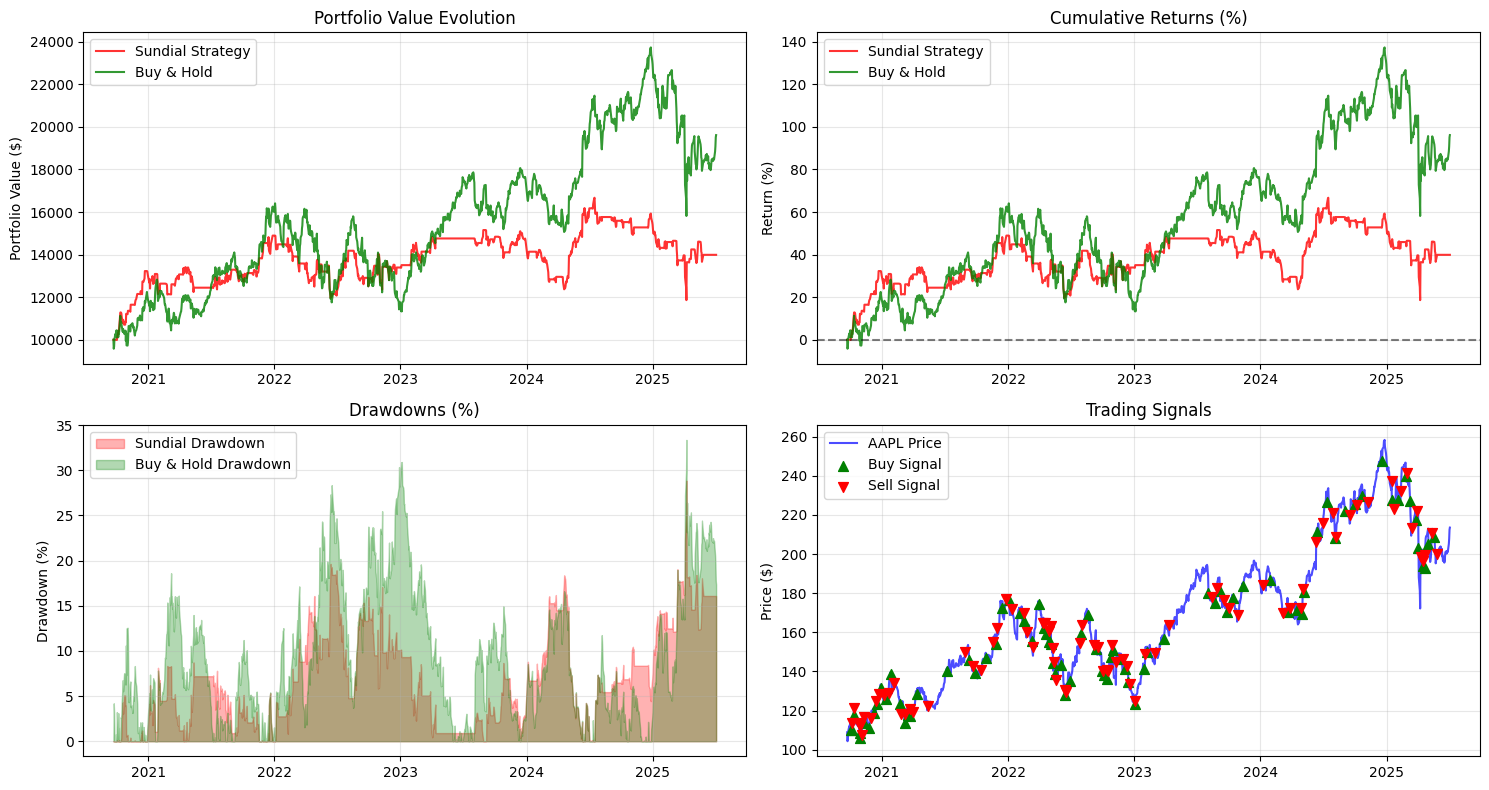

In [44]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(dates, sundial_values, label='Sundial Strategy', color='red', alpha=0.8)
plt.plot(dates, buy_hold_values, label='Buy & Hold', color='green', alpha=0.8)
plt.title('Portfolio Value Evolution')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sundial_cumulative = [(v/initial_capital - 1) * 100 for v in sundial_values]
buy_hold_cumulative = [(v/initial_capital - 1) * 100 for v in buy_hold_values]

plt.plot(dates, sundial_cumulative, label='Sundial Strategy', color='red', alpha=0.8)
plt.plot(dates, buy_hold_cumulative, label='Buy & Hold', color='green', alpha=0.8)
plt.title('Cumulative Returns (%)')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.subplot(2, 2, 3)
def calculate_drawdown_series(values):
    peak = values[0]
    drawdowns = []
    for value in values:
        if value > peak:
            peak = value
        dd = (peak - value) / peak * 100
        drawdowns.append(dd)
    return drawdowns

sundial_dd = calculate_drawdown_series(sundial_values)
buy_hold_dd = calculate_drawdown_series(buy_hold_values)

plt.fill_between(dates, sundial_dd, 0, alpha=0.3, color='red', label='Sundial Drawdown')
plt.fill_between(dates, buy_hold_dd, 0, alpha=0.3, color='green', label='Buy & Hold Drawdown')
plt.title('Drawdowns (%)')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
if len(sundial_strategy.trades) > 0:
    plt.plot(data.index[start_idx:], data['Close'].iloc[start_idx:], 
             label='AAPL Price', color='blue', alpha=0.7)
    
    
    buy_trades = [t for t in sundial_strategy.trades if t['action'] == 'BUY']
    sell_trades = [t for t in sundial_strategy.trades if t['action'] == 'SELL']
    
    if buy_trades:
        buy_dates = [t['date'] for t in buy_trades]
        buy_prices = [t['price'] for t in buy_trades]
        plt.scatter(buy_dates, buy_prices, color='green', marker='^', 
                   s=50, label='Buy Signal', zorder=5)
    
    if sell_trades:
        sell_dates = [t['date'] for t in sell_trades]
        sell_prices = [t['price'] for t in sell_trades]
        plt.scatter(sell_dates, sell_prices, color='red', marker='v', 
                   s=50, label='Sell Signal', zorder=5)
    
    plt.title('Trading Signals')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [45]:
summary_data = {
    'Strategy': ['Sundial Foundation Model', 'Buy & Hold'],
    'Final Value': [f'${final_sundial:,.2f}', f'${final_buy_hold:,.2f}'],
    'Total Return': [f'{sundial_return:+.1f}%', f'{buy_hold_return:+.1f}%'],
    'Annual Volatility': [f'{sundial_volatility:.1f}%', f'{buy_hold_volatility:.1f}%'],
    'Sharpe Ratio': [f'{sundial_sharpe:.2f}', f'{buy_hold_sharpe:.2f}'],
    'Max Drawdown': [f'{sundial_max_dd:.1f}%', f'{buy_hold_max_dd:.1f}%'],
    'Number of Trades': [f'{num_trades}', '1']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


                Strategy Final Value Total Return Annual Volatility Sharpe Ratio Max Drawdown Number of Trades
Sundial Foundation Model  $13,989.95       +39.9%             20.4%         1.86        28.8%              160
              Buy & Hold  $19,612.79       +96.1%             28.9%         3.26        33.4%                1
